### Load the model with pretrained weights

In [1]:
import torch
from torchvision.models import resnet101
from torchvision.models import ResNet101_Weights

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model_resnet101 = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
model_resnet101 = model_resnet101.to(device)

### Model summary

In [4]:
!pip install torchinfo

In [5]:
from torchinfo import summary
summary(model=model_resnet101, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

### Image and Visualization

In [13]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def vis_plain(layer_num, img, model, device):

    # transforms
    transforms_imagenet = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                   std=(0.229, 0.224, 0.225))])
    img = transforms_imagenet(img).unsqueeze_(dim=0)

    # device-agnostic
    model = model.to(device)
    img = img.to(device)

    # Hook function
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)

    layer = dict(model_resnet101.layer3.named_modules())['']._modules['15'].conv1
    handle = layer.register_forward_hook(hook_fn)

    # Forward pass the image through the model
    model.eval()
    with torch.inference_mode():
        preds = model(img)

    pred_cls_idx = preds.argmax(dim=1)
    print(f"Predicted class id : {pred_cls_idx}")

    feature_map = feature_maps[0]
    print(f"Feature Map shape : {feature_map.shape}")

    # Plot the feature maps
    layer_output = feature_map.squeeze()
    rows, cols = 3, 5
    fig = plt.figure(figsize=(15, 9))
    for i in range(1, (rows * cols) + 1):
        feature_map = layer_output[i-1, :, :].cpu().numpy()
        fig.add_subplot(rows, cols, i)
        plt.imshow(feature_map, cmap='viridis')
        # plt.tight_layout()
        plt.axis(False)

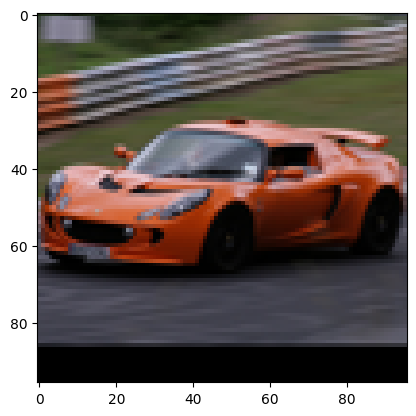

In [14]:
import PIL.Image as Image

# Using a car image downloaded from the test set of STL-10
# https://www.kaggle.com/datasets/jessicali9530/stl10
img_car = Image.open("./car.png")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

plt.imshow(img_car)

Predicted class id : tensor([817], device='cuda:0')
Feature Map shape : torch.Size([1, 256, 14, 14])


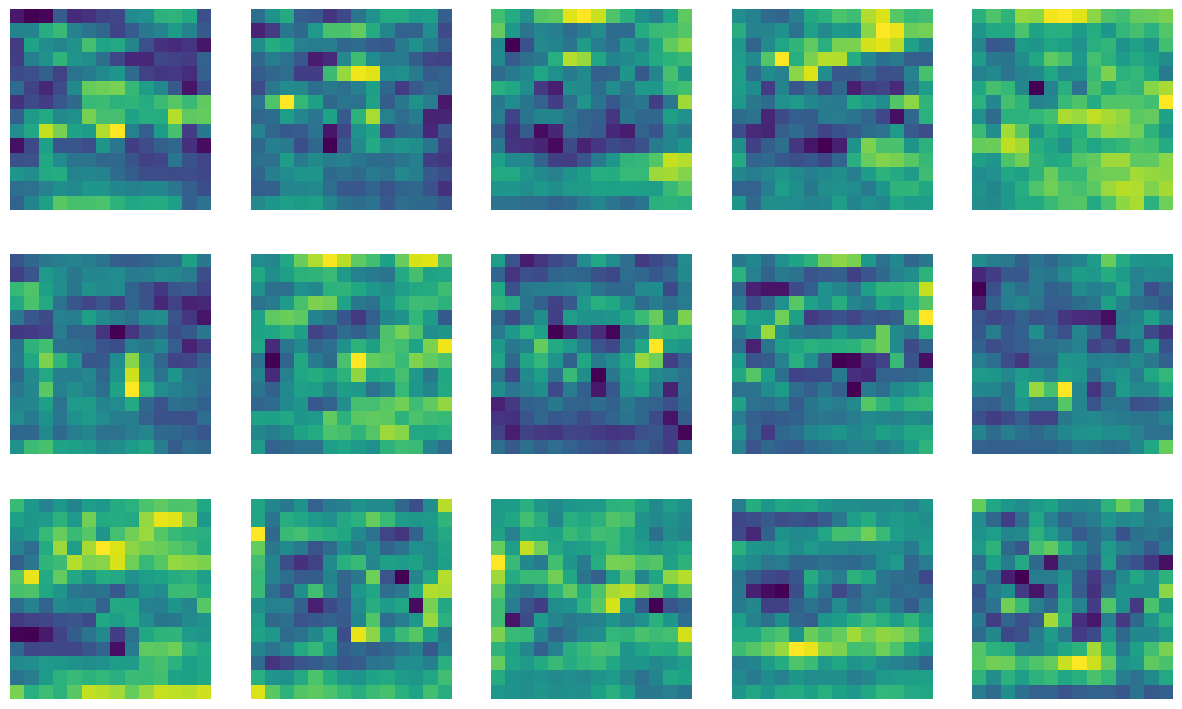

In [15]:
vis_plain(10, img_car, model_resnet101, device)